In [1]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from model import TimeStepEmbedding

In [9]:
pos_enc

TimeStepEmbedding(
  (mlp): Sequential(
    (0): Linear(in_features=256, out_features=384, bias=True)
    (1): SiLU()
    (2): Linear(in_features=384, out_features=384, bias=True)
  )
)

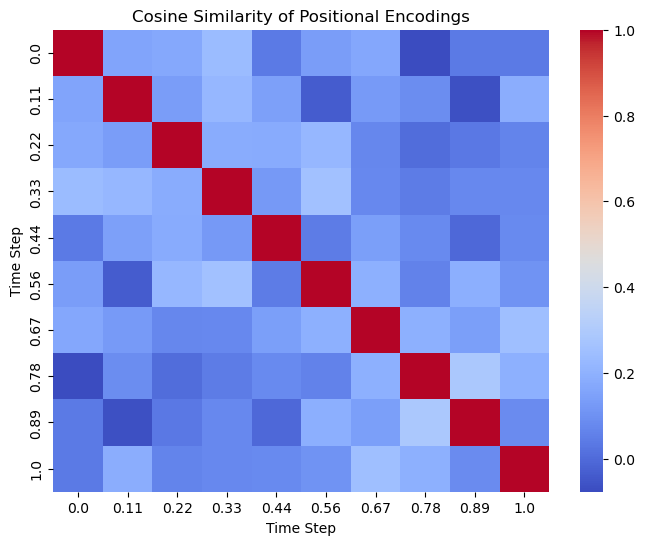

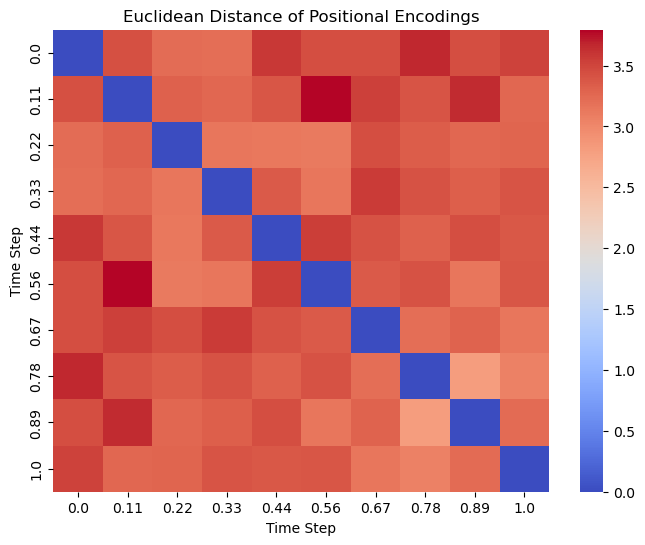

In [8]:
pos_enc = TimeStepEmbedding(384)
num_bins = 10
timesteps = torch.linspace(0, 1, num_bins)
embeddings = pos_enc(timesteps).detach().numpy()
import seaborn as sns
from scipy.spatial.distance import cdist

# Compute cosine similarity and Euclidean distance matrices
cosine_sim_matrix = 1 - cdist(embeddings, embeddings, metric="cosine")
euclidean_dist_matrix = cdist(embeddings, embeddings, metric="euclidean")

# Plot Cosine Similarity Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cosine_sim_matrix, cmap="coolwarm", annot=False, xticklabels=np.round(timesteps.numpy(), 2), yticklabels=np.round(timesteps.numpy(), 2))
plt.title("Cosine Similarity of Positional Encodings")
plt.xlabel("Time Step")
plt.ylabel("Time Step")
plt.show()

# Plot Euclidean Distance Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(euclidean_dist_matrix, cmap="coolwarm", annot=False, xticklabels=np.round(timesteps.numpy(), 2), yticklabels=np.round(timesteps.numpy(), 2))
plt.title("Euclidean Distance of Positional Encodings")
plt.xlabel("Time Step")
plt.ylabel("Time Step")
plt.show()



In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

/media/newhd/ayan/diffusion_exps/envs/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

class CIFAR_CONFIG:
    image_size = 32
    num_classes = 10
    train_images = 50000
    val_images = 10000
    num_channels = 3
    root = '../data'

def get_dataset(name, config):
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: 2*x - 1.0),
    ])
    root = getattr(config, 'root', './data')
    train_set = datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)

    return train_set


Files already downloaded and verified


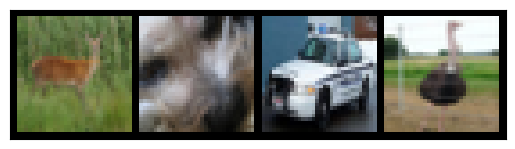

In [43]:
trainset = get_dataset('cifar10', CIFAR_CONFIG)
train_loader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2) 
batch = next(iter(train_loader))
show(make_grid(((batch[0] + 1) / 2), 4))

In [5]:
from diffusers import AutoencoderKL

In [49]:
# def patchify(img_batch, patch_size):
#     B,C,H,W = img_batch.shape
#     assert H % patch_size == 0 and W % patch_size == 0
#     patches = img_batch.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)  

In [55]:
patch_size = 2
B,C,H,W = batch[0].shape
assert H % patch_size == 0 and W % patch_size == 0
patches = batch[0].unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
print(patches.shape)


torch.Size([4, 3, 16, 16, 2, 2])


In [57]:
# reshape to B, Num_patches, C, patch_size, patch_size
patches.contiguous().view(B, C, -1, patch_size, patch_size).permute(0, 2, 1, 3, 4).shape

torch.Size([4, 256, 3, 2, 2])